In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation

## Voronoi Grids

Voronoi grids offer a structure that is somewhat organic and disordered at the cost of computational complexity. 

Voronoi grids are created by first distributing a number of nodes randomly across a plane. Points on the plane are now defined by whichever node is closest to it, and the size and shape of each cell is irregular because the nodes were distributed randomly. Adjacencies are much more random, and anything propagating through the grid no longer does so uniformly. This irregularity comes with a number of advantages and disadvantages.

Remember that in the hexagonal grid, waves propagated hexagonally; in a voronoi grid, the irregular shape of each cell results in a more smoothed propagation pattern. However, this irregular shape also means that cells are not a uniform distance apart from each other. Physical distance in the grid is no longer strictly related to the number of iterations it will take for a signal to propagate between two points. As a result, self exciting loops can form relatively easily (which are really cool!). Self exciting loops are any situation where a signal in the network can loop back onto the original source node and cause the same signal to propagate once more. These loops can be undesireable, and are generally much more difficult to create with ordered networks, unless you are deliberately attempting to create one. 

The creation of the network is also computationally expensive, particularly with this approach. This voronoi mapping method is rasterized, which means that space has been discretized. The closest node is computed for each discretized point in the grid. This is perhaps the most inefficient way to implement a voronoi grid. There are much more elegant ways to compute voronoi structure using convex hull algorithms. However, this method was chosen because it plays nicely with matplotlib's existing plotting functions and is relatively simple to code. Once the grid is created and adjacencies are computed, any algorithms run with the same speed as with an ordered grid. 

Let's take a look at this example of a wave propagating through a voronoi grid. The steps for the algorithm are as follows:

1. Randomly distribute nodes throughout a plane. The number of nodes is defined by 'cell_count'

2. Calculate the closest node for each discrete point in the plane. The level of resolution of these discrete points is defined by 'grid_resolution'

3. Determines which cells are adjacent to one another by iterating over the grid in the x and y direction and documenting when a cell change occurs

3. Activate a single cell in the grid. With each iteration, all activated cells activate their adjacent cells. When cells are turned off, they are placed on a short cooldown before they can activate again. This delay is defined by 'delay'

4. Every few frames, a random cell is activated, and another wave propagates through the system. The number of frames between activation is 'beat_rate'


In [2]:
# finds the closest node from a certain position
def closest_node(position, nodes):
    diff = np.subtract(nodes, position)
    
    errors = np.sum(np.square(diff), axis = 1)
    closest = np.argmin(errors)
    
    return nodes[closest], closest

In [3]:
# Creates a Voronoi grid
#
# Returns a matrix of grid_resolution x grid_resolution. Each value 
# in this matrix refers to whichever node was closest to 
# that point on the grid. For example, all entries in the matrix
# whose value is 18 are a part of the same voronoi cell
def voronoi_mapping(grid_resolution, cell_count):  
    
    nodes = []
    random.seed(1373)
    for i in range(cell_count):
        # creates a node at a random location
        curr_x = random.random()
        curr_y = random.random()
        curr_node = (curr_x, curr_y)
        nodes.append(curr_node)
        
    # iterates over a square grid whose resolution is grid_resolution.
    # At each point in the grid, determines which node is closest
    axis = np.linspace(0, 1, grid_resolution, endpoint = False)
    voronoi_map = []
    for x in axis:
        temp_map = []
        for y in axis:
            curr_position = [x, y]
            voro_node, node_index = closest_node(curr_position, nodes)
            temp_map.append(node_index)
            
        voronoi_map.append(temp_map)
        
    return voronoi_map, nodes
            

In [4]:
# creates a dictionary of a cell's adjacencies
# For example, if cell 0 is adjacent to cell 4, 9, and 21,
# the entry adj_dict[0] would be equal to [4, 9, 21]
def gen_adj_dict(voronoi_map, nodes):
    grid_resolution = len(voronoi_map)
    cell_count = len(nodes)
    
    # each cell's adjacencies are stored in a set
    adj_dict = {i : set() for i in range(cell_count)}
    
    # iterates over the map in the y direction
    # detects when a change in cells occurs, and 
    # documents that as an adjacency
    prev = voronoi_map[0][0]
    for x in range(grid_resolution): # for every x value
        prev_node = voronoi_map[x][0]
        for y in range(grid_resolution): # iterates in the y direction
            curr_node = voronoi_map[x][y]
            if curr_node != prev_node: # detects changes in the closest node
                adj_dict[curr_node].add(prev_node)
                adj_dict[prev_node].add(curr_node)
            prev_node = curr_node
            
    for y in range(grid_resolution): # for every y value
        prev_node = voronoi_map[0][y]
        for x in range(grid_resolution): # iterates in the x direction
            curr_node = voronoi_map[x][y]
            if curr_node != prev_node: # detects changes in the closest node
                adj_dict[curr_node].add(prev_node)
                adj_dict[prev_node].add(curr_node)
            prev_node = curr_node
            
    return adj_dict

In [5]:
# Updates the plot for the current iteration, so that 
# the renderer knows what to animate
def update_plot(voronoi_map, node_state):
    grid_resolution = len(voronoi_map)
    plot_grid = np.zeros((grid_resolution, grid_resolution))
    
    for x in range(grid_resolution):
        for y in range(grid_resolution):
            curr_node = voronoi_map[x][y]
            if node_state[curr_node]:
                plot_grid[x][y] = ON
                
    return plot_grid

In [6]:
# plots the voronoi map for your viewing pleasure
def plot_voronoi(voronoi_map, grid_resolution):
    heatmap = np.empty((grid_resolution, grid_resolution))
    for x in range(grid_resolution):
        for y in range(grid_resolution):
            heatmap[x][y] = voronoi_map[x][y]
            
    plt.figure(figsize = (8,8))
    plt.imshow(heatmap, cmap = "RdBu")
    plt.show()

#### Parameters - play with these!

In [7]:
# Animation parameters!
#
# Some notes:
# - voronoi_mapping is horribly inefficient, and has 
#   O(grid_resolution^2 * cell_count)
#
# - A good number for cell_count is typically 1 - 6 times grid_resolution
#
# - grid_resolution should be greater than 100 to properly see the waves, but I
#   recommend using a value around 400 or more
#
# - because of the structure of the system, self-exciting loops can happen when 
#   the delay of one wave interferes with the propagation of the next! There's a 
#   list of parameters at the bottom of this cell you can try if you're interested.
#   Fun fact, this is the same mechanism that causes heart attacks.



grid_resolution = 400 # resolution of the grid across each axis
cell_count = 800 # the number of voronoi cells
delay = 5 # cooldown time of each cell
beat_rate = 25 # how often a new wave is initiated
seed_node = 0 # the starting cell


# Self-exciting loop parameters
grid_resolution = 400
cell_count = 800
delay = 5
beat_rate = 20
seed_node = 0

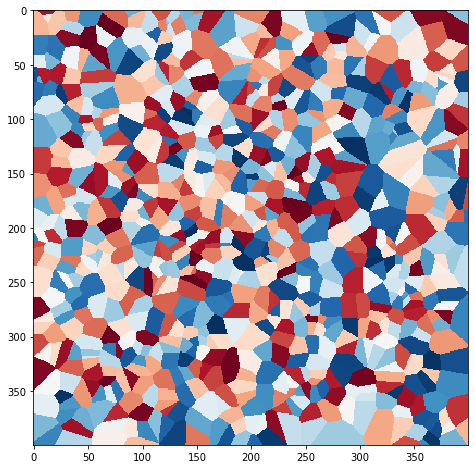

In [8]:
# this step can take a long time to run, so its in its own cell. Only run this
# if you have changed grid_resolution or cell_count
#
# For reference, with the default values of 400 and 800, this cell takes around 
# a minute to run on my computer
voronoi_map, nodes = voronoi_mapping(grid_resolution, cell_count)
adj_dict = gen_adj_dict(voronoi_map, nodes)
plot_voronoi(voronoi_map, grid_resolution)

In [9]:
ON = 255
OFF = 0
random.seed(1373)

node_cooldown = {i : 0 for i in range(cell_count)}
node_state = {i : OFF for i in range(cell_count)}

# this init function looks useless, but for some reason,
# the renderer starts on frame 3 without it. With this
# function, it starts on frame 2
def init():
    return mat

def transition(data):
    
    # decrements the cooldown of each node by one
    for node in node_cooldown:
        if node_cooldown[node] > 0:
            node_cooldown[node] -= 1
    
    node_state_copy = node_state.copy()
    for node in node_state.keys():
        
        # if a node is activated
        if node_state_copy[node] == ON:
            # activate its neighbors, if they aren't cooling down
            for neighbor in adj_dict[node]:
                if node_cooldown[neighbor] == 0:
                    node_cooldown[neighbor] = delay
                    node_state[neighbor] = ON
            # deactivate that node
            node_state[node] = OFF

    
     # reignites a random node one every beat_rate frames
    if (data + 1) % beat_rate == 0:
        beat_seed = int(random.random() * cell_count)
        node_state[beat_seed] = ON
        node_cooldown[beat_seed] = delay
        
    plot_grid = update_plot(voronoi_map, node_state)
    
    # updates the plot's data, allowing the renderer to redraw the plot
    mat.set_data(plot_grid)

    return mat

node_state[seed_node] = ON
node_cooldown[seed_node] = delay
plot_grid = update_plot(voronoi_map, node_state)

fig, ax = plt.subplots(figsize = (6,6))
mat = ax.matshow(plot_grid, cmap="plasma")
ani = animation.FuncAnimation(fig, transition, interval = 50, save_count=50, init_func = init)
plt.close(fig)

from IPython.display import HTML
HTML(ani.to_jshtml())

### Notes on Results:

Notice that the waves in the voronoi grid are comparatively smoothed and circular in comparsion to the hexagonal grid!

The fact that voronoi grids can create self-exciting networks is generally an issue. However, there are applications where such behavior is desired, such as research into heart dynamics. This is a real thing, check out Dr. Flavio Fenton's research here at Georgia Tech for more information into the chaotic nature of waves in hearts. 